# **PRODUCT SALES ANALYSIS**

GOAL:

*  Enhance the effectiveness of sales methods for new product lines.
*   Optimize resource allocation by identifying the most efficient sales approaches







In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import csv data and create a dataframe
df = pd.read_csv("product_sales.csv")

In [3]:
df.head(10)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
5,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi
6,4,Email,eb6bd5f1-f115-4e4b-80a6-5e67fcfbfb94,11,113.38,9,28,Georgia
7,1,Email,047df079-071b-4380-9012-2bfe9bce45d5,10,99.94,1,22,Oklahoma
8,5,Email,771586bd-7b64-40be-87df-afe884d2af9e,11,108.34,10,31,Massachusetts
9,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri



We need to know:
- How many customers were there for each approach?
- What does the spread of the revenue look like overall? And for each method?
- Was there any difference in revenue over time for each of the methods?
- Based on the data, which method would you recommend we continue to use? Some
of these methods take more time from the team so they may not be the best for us
to use if the results are similar.

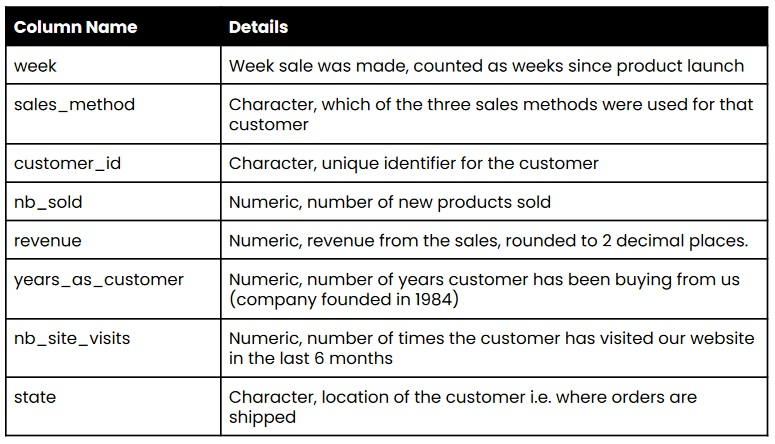

In [4]:
# Checking for missing values and finding each column data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
# We can see there are some missing values in the revenue column.
# Let's check each column for data validation and its need for cleaning.

# 1- Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64


In [6]:
# 2 - Data validation: Check the unique values to identify any unexpected or erroneous data.
unique_values = df.nunique()
print(unique_values)

week                     6
sales_method             5
customer_id          15000
nb_sold                 10
revenue               6743
years_as_customer       42
nb_site_visits          27
state                   50
dtype: int64


In [7]:
# Check for outliers: Using summary statistics such as mean, median,
# standard deviation, and quartiles, we can identify outliers in numeric columns.
summary_stats = df.describe().round(2)
print(summary_stats)

           week   nb_sold   revenue  years_as_customer  nb_site_visits
count  15000.00  15000.00  13926.00           15000.00        15000.00
mean       3.10     10.08     93.93               4.97           24.99
std        1.66      1.81     47.44               5.04            3.50
min        1.00      7.00     32.54               0.00           12.00
25%        2.00      9.00     52.47               1.00           23.00
50%        3.00     10.00     89.50               3.00           25.00
75%        5.00     11.00    107.33               7.00           27.00
max        6.00     16.00    238.32              63.00           41.00


There are 1074 missing values in revenue column. In sales_method column we see 5 different method which is wrong (we should have 3 type of methods, and there are outliers in years_as_customer, because the company founded in 1984 and we can't have a customers since 63 years ago

In [8]:
# Proportion of missing values relative to the total entries in the revenue column
(df['revenue'].isna().sum()/df['revenue'].count())*100

7.7121930202498925

There are more than 5 percent missing values in revenue column,  so we can not easily drop them unless we examine randomness of missing values. If they are missing completely at random (MCAR) or missing at random (MAR), dropping them may be less problematic. However, if they are missing not at random (MNAR), dropping them could introduce bias.

In [9]:
# We should have 3 unique values in sales_method column.
unique_values = df['sales_method'].unique()
print(unique_values)

['Email' 'Email + Call' 'Call' 'em + call' 'email']


In [10]:
# Standardize the values in the 'sales_method' column by replacing 'em + call' with 'Email + Call' and 'email' with 'Email'
# Create a copy of the original DataFrame
df_corrected = df.copy()

# Replace values in the 'sales_method' column
df_corrected['sales_method'] = df['sales_method'].replace({'em + call': 'Email + Call', 'email': 'Email'})

# Check the unique values in the 'sales_method' column after replacement
unique_sales_method = df_corrected['sales_method'].unique()
print("Unique values in the sales_method column after replacement:", unique_sales_method)


Unique values in the sales_method column after replacement: ['Email' 'Email + Call' 'Call']


In [11]:
# Values greater than 40 in years_as_customer are wrong and we should consider them as outliers
df_corrected[df_corrected['years_as_customer']>40]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


In [12]:
# There are only two records as years_as_customer outliers, so we can easily drop them.
# Filter records where 'years_as_customer' is less than or equal to 40
df_filtered = df_corrected[df_corrected['years_as_customer'] <= 40]

# Check the number of records before and after filtering
print("Number of records before filtering:", len(df_corrected))
print("Number of records after filtering:", len(df_filtered))


Number of records before filtering: 15000
Number of records after filtering: 14998


In [13]:
# To conduct a statistical test to determine if there is a relationship between missing values in the 'revenue'
# column and the 'sales_method' column, we can use a chi-square test of independence. This test is appropriate
# when both variables are categorical, so we first create a categorical revenue column.

# Replace NaN values with "Null" and non-NaN values with "Not_Null"
df_filtered['revenue_category'] = df_filtered['revenue'].fillna('Null').map(lambda x: 'Not_Null' if x != 'Null' else x)

# Check the unique values in the 'revenue_category' column
unique_revenue_category = df_filtered['revenue_category'].unique()
print("Unique values in the revenue_category column:", unique_revenue_category)




Unique values in the revenue_category column: ['Null' 'Not_Null']


<ipython-input-13-8fa6b41687bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['revenue_category'] = df_filtered['revenue'].fillna('Null').map(lambda x: 'Not_Null' if x != 'Null' else x)


In [14]:
df_filtered.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_category
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona,Null
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas,Not_Null
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Not_Null
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana,Null
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois,Not_Null


In [15]:
# To conduct a chi-square test of independence between the 'sales_method' and 'revenue_category' columns,
# we first need to create a contingency table representing the frequencies of each combination of categories.
# Then, we can use the chi2_contingency function from the scipy.stats module to perform the test.

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_filtered['sales_method'], df_filtered['revenue_category'])

# Print the contingency table
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print("\nChi-square statistic:", chi2)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("\nThere is a significant relationship between 'sales_method' and 'revenue_category'.")
else:
    print("\nThere is no significant relationship between 'sales_method' and 'revenue_category'.")


Contingency Table:
revenue_category  Not_Null  Null
sales_method                    
Call                  4780   181
Email                 6921   544
Email + Call          2223   349

Chi-square statistic: 251.11783987671868
p-value: 2.954295391738752e-55

There is a significant relationship between 'sales_method' and 'revenue_category'.


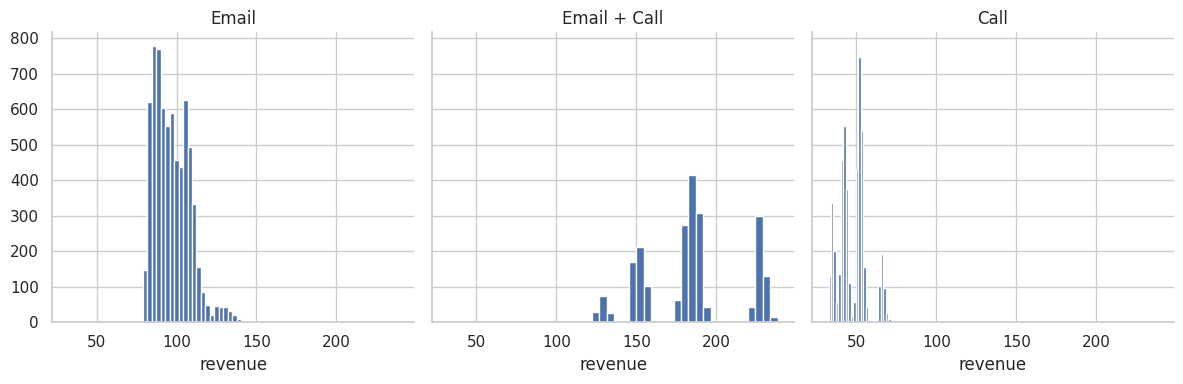

In [16]:
# Because there is a significant relationship between 'sales_method' and 'revenue_category', we can not easily drop
# missing values. In such cases, simply dropping missing values may introduce bias into your analysis.

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a facet grid using seaborn
g = sns.FacetGrid(df_filtered, col="sales_method", col_wrap=3, height=4)

# Map a histogram for 'revenue' onto the grid
g.map(plt.hist, "revenue", bins=25)

# Add titles
g.set_titles("{col_name}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



In [17]:
# When the distribution of revenue for each sales method is not normal, it's generally advisable to use the median for imputation rather than the mean.

# Function to perform stratified imputation
def stratified_imputation(group):
    # Calculate median of 'revenue' within each group
    median_revenue = group['revenue'].median()
    # Impute missing values with the median within each group
    group['revenue'] = group['revenue'].fillna(median_revenue)

    return group

# Group the DataFrame by 'sales_method' and apply stratified imputation
df_imputed = df_filtered.groupby('sales_method').apply(stratified_imputation)

# Check if there are still any missing values in 'revenue' column
missing_values = df_imputed['revenue'].isnull().sum()
print("Number of missing values after imputation:", missing_values)


Number of missing values after imputation: 0


In [19]:
df_ready = df_imputed.reset_index(drop=True)
df_ready

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_category
0,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Not_Null
1,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi,Not_Null
2,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri,Not_Null
3,2,Call,c20ab049-cbac-4ba7-8868-310aa89e0549,9,45.42,2,23,New York,Not_Null
4,5,Call,0b026b91-fe12-4af0-86f9-387ba81c8fdb,11,53.42,2,30,Maryland,Not_Null
...,...,...,...,...,...,...,...,...,...
14993,4,Email + Call,e599ac4d-4634-49a6-b373-04c021d3a1ab,12,180.71,9,28,South Carolina,Not_Null
14994,3,Email + Call,86756cf2-5ad6-4fc8-8d65-557e4c946174,10,149.12,4,24,Kentucky,Not_Null
14995,2,Email + Call,b5c6d6e0-1237-4785-b088-17064d44d366,10,149.57,1,30,Virginia,Not_Null
14996,5,Email + Call,cd9e6945-ae21-4bed-a6cf-f0302e6c4795,12,184.74,1,34,New York,Null


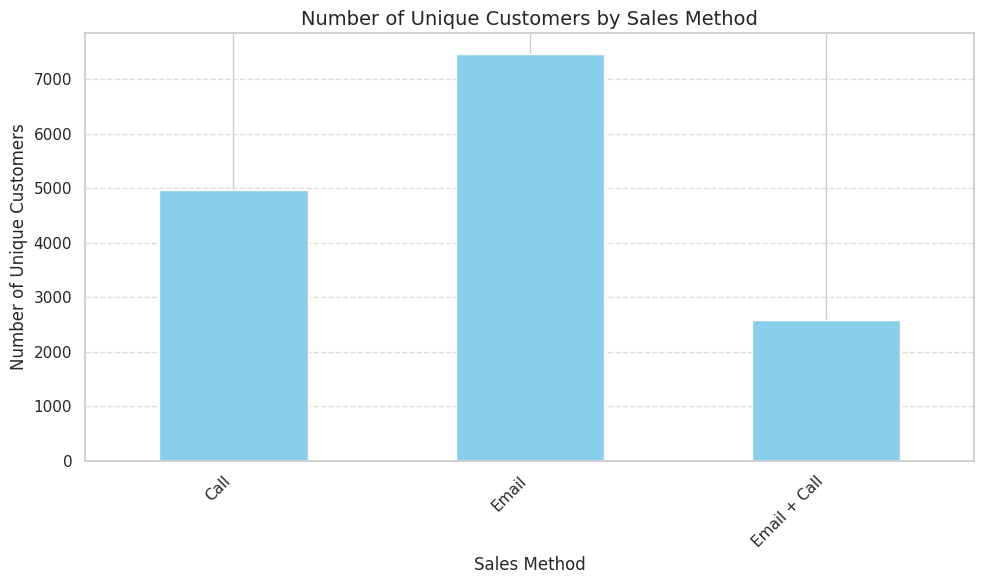

In [20]:
customer_counts = df_ready.groupby('sales_method')['customer_id'].nunique()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
customer_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Unique Customers by Sales Method', fontsize=14)
plt.xlabel('Sales Method', fontsize=12)
plt.ylabel('Number of Unique Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The bar chart illustrating the sales methods reveals that the Email method achieved the best results, with 7,465 sales. This was followed by the Call method, which garnered 4,961 sales, and the combined Email + Call method, which accounted for 2,572 sales. Notably, the Email method alone contributed to approximately 50% of the total sales.

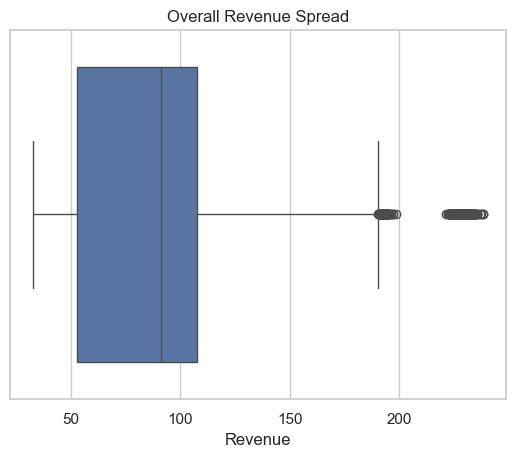

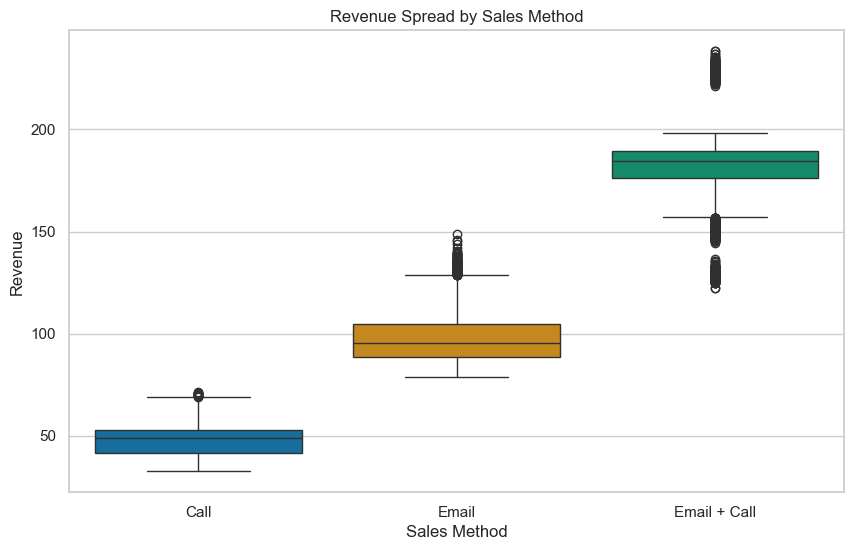

In [ ]:

# Overall revenue spread
sns.boxplot(data=df_ready, x='revenue')
plt.title('Overall Revenue Spread')
plt.xlabel('Revenue')
plt.show()

# Revenue spread for each sales method
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ready, x='sales_method', y='revenue', hue='sales_method', palette='colorblind')
plt.title('Revenue Spread by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.show()


In [ ]:
# Median revenue for each sales method
median_df = df_ready.groupby('sales_method')['revenue'].median()

# To display the resulting DataFrame
print(median_df)

sales_method
Call             49.05
Email            95.58
Email + Call    184.74
Name: revenue, dtype: float64


The boxplot of revenue spread reveals a median revenue per customer slightly below 100.00, with a concentration of revenues between 50.00 and 100.00. The presence of outliers above 190.00 suggests a few high-spending customers. These findings indicate a pricing strategy that resonates with a large portion of the customer base, while the outliers may represent a distinct segment worth targeting.


Upon analyzing the distribution of revenues by sales method, distinct differences emerge in terms of their medians and spread. The Email + Call method is particularly notable, exhibiting a wider spread and a higher median revenue of approximately 184.74. The Call method, in contrast, shows a narrow spread with a significantly lower median of around 49.05. The Email method occupies a middle ground, characterized by a narrow spread but a median revenue of 95.58, which is higher than that of the Call method

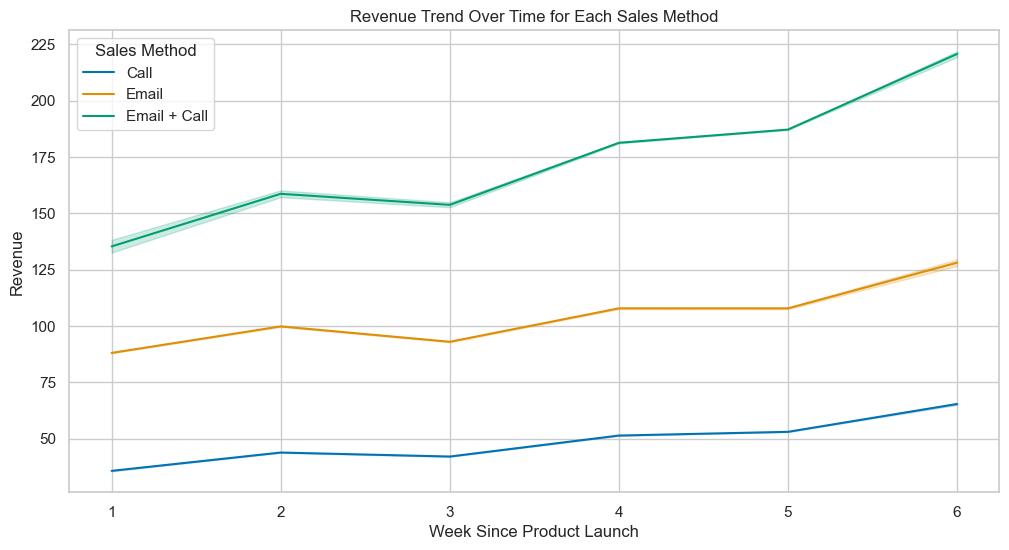

In [ ]:
# To analyze the difference in revenue over time for each sales method, we can create line plots showing the trend of revenue over the weeks since
# the product launch

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot revenue over time for each sales method
sns.lineplot(data=df_ready, x='week', y='revenue', hue='sales_method', palette='colorblind')

# Add title and labels
plt.title('Revenue Trend Over Time for Each Sales Method')
plt.xlabel('Week Since Product Launch')
plt.ylabel('Revenue')

# Show the plot
plt.legend(title='Sales Method')
plt.show()


The line chart illustrates the revenue trend for different sales methods over time. The data reveals that the combined approach of email and call follow-ups consistently outperforms both email and call alone in terms of revenue generation. While email shows a steady increase in revenue, call has the lowest overall performance. These findings suggest that the Email + Call method is the most effective sales strategy and should be further optimized to maximize revenue.

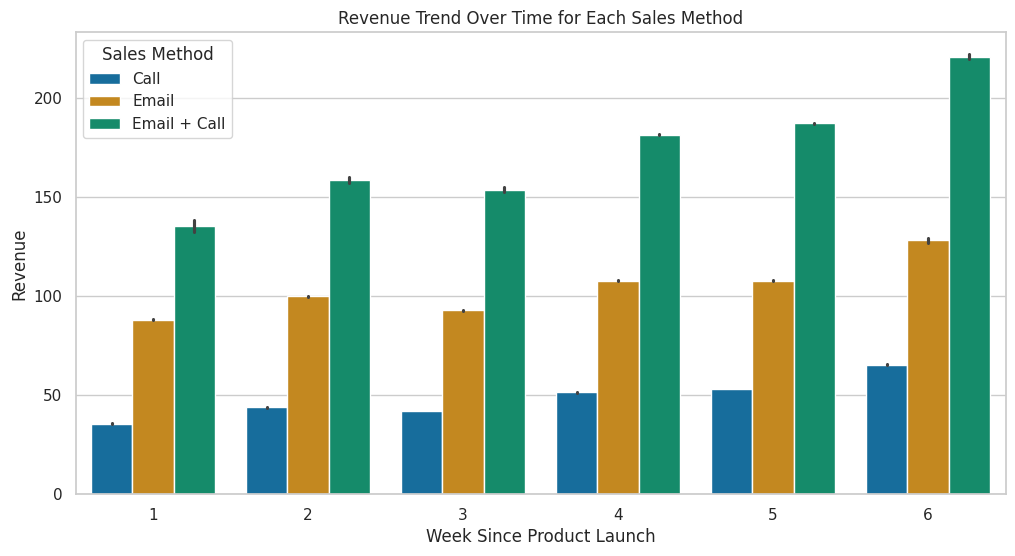

In [21]:
plt.figure(figsize=(12, 6))

# Plot revenue over time for each sales method
sns.barplot(data=df_ready, x='week', y='revenue', hue='sales_method', palette='colorblind')

# Add title and labels
plt.title('Revenue Trend Over Time for Each Sales Method')
plt.xlabel('Week Since Product Launch')
plt.ylabel('Revenue')

# Show the plot
plt.legend(title='Sales Method')
plt.show()

The analysis of revenue over time for each method reveals a steady growth in the Call sales method. The Email method also shows a gradual increase, though with some fluctuations. In contrast, the Email + Call method demonstrates more pronounced growth in revenue, consistently outperforming both the Email and Call methods.

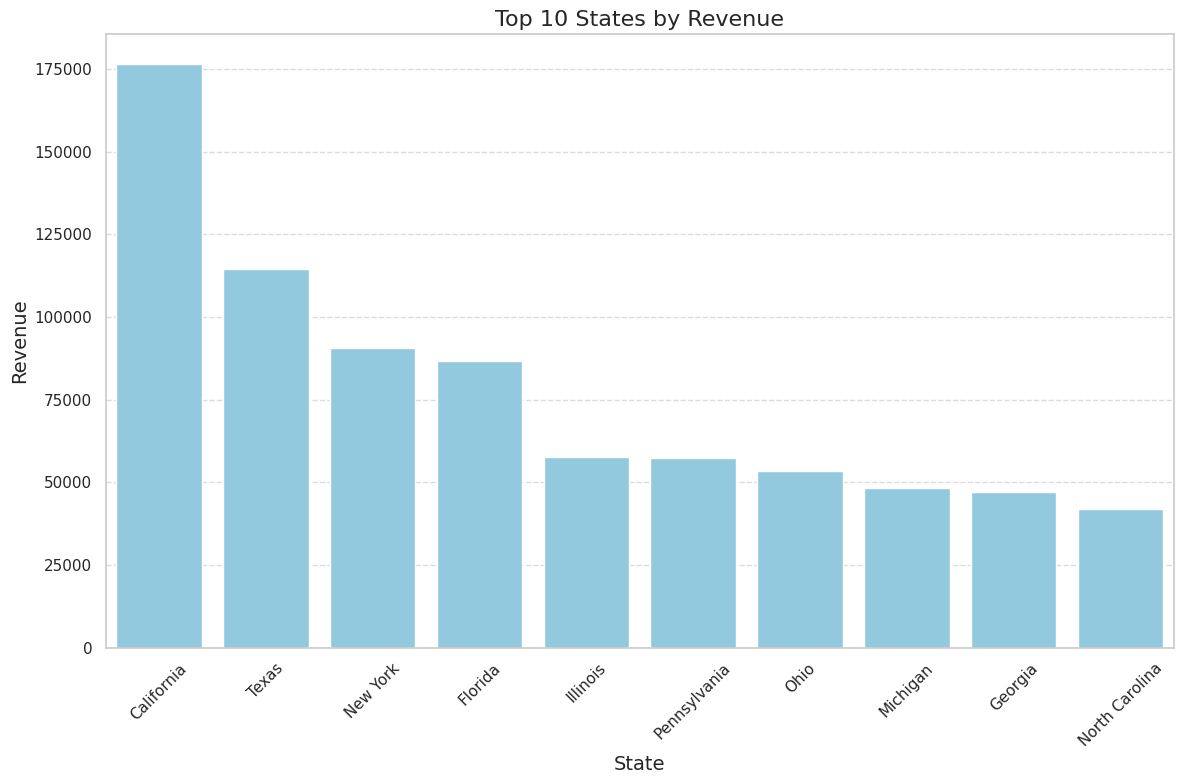

In [24]:
#OTHER FINDINGS

top_10_states_revenue = df_ready.groupby('state')['revenue'].sum().sort_values(ascending=False).head(10).reset_index()

# Creating a column graph to visualize the top 10 states that accounted for the most revenue
plt.figure(figsize=(12, 8))
sns.barplot(x='state', y='revenue', data=top_10_states_revenue, color='skyblue')
plt.title('Top 10 States by Revenue', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Top 10 states by revenue The bar chart ranks the top 10 states by revenue, revealing a significant disparity between California and the other states. California's revenue generation far exceeds that of Texas and New York, which occupy the second and third positions, respectively. The remaining states exhibit relatively similar revenue levels, with North Carolina ranking lowest among the top 10. This disparity could be attributed to factors such as population size, economic activity, market size, or industry concentration in California

# **CONCLUSION**

The primary goals of the project are to enhance the effectiveness of sales methods for new product lines and to optimize resource allocation by identifying the most efficient sales approaches. By analyzing customer counts, revenue distributions, and revenue growth trends for each sales method (Email, Call, Email + Call), the analysis aims to determine which method generates the highest revenue and shows the most significant growth. This approach directly addresses the business problem of selecting the most effective sales strategy, ensuring that investments are focused on methods that offer the best returns.
Based on the analysis, the recommendation is to continue using the Email + Call method, as it demonstrated the highest median revenue and significant revenue growth over time. The Call method, with its lower revenue efficiency, may warrant reconsideration or optimization. This recommendation will help streamline resource allocation and improve overall sales performance by focusing on the most effective sales strategies.

To support our goal of increasing product sales and fostering customer creativity, I recommend monitoring the percentage of sales made through the Email + Call method over the past six weeks. This metric is particularly relevant as the Email method requires minimal effort from the team, while each Call takes about ten minutes per customer, based on data from recent months.